Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


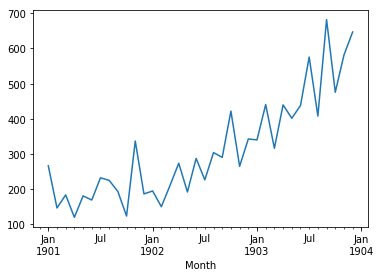

In [3]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [7]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [37]:
import numpy

In [18]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [4]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

## Walk-forward validation - persistence

RMSE: 136.761


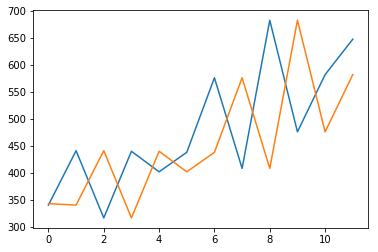

In [8]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

## LSTM Data Preparation

## Differencing

In [10]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [11]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [19]:
raw_values = series.values
diff_values = difference(raw_values, 1)

## Transform to supervised learning

In [9]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [24]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [25]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

## Normalization

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [27]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [28]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [29]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

## LSTM Model Development

In [40]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=False, shuffle=False)
        model.reset_states()
    return model

In [33]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

Epoch 1/1
23/23 [==============================] - 1s 30ms/step - loss: 0.2507
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2474
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2450
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2430
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2412
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2396
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2381
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2368
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2356
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2345
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2334
Epoch 1/1
23/23 [==============================] - 0s 2ms/step - loss: 0.2323
Epoch 1/1
23/23 [==============================] - 0s 2ms/step 

In [35]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.10980968],
       [ 0.25254649],
       [-0.15272789],
       [ 0.18999545],
       [-0.40176249],
       [-0.03822173],
       [-0.44926488],
       [-0.07039203],
       [-0.03121586],
       [ 0.18879254],
       [-0.89420855],
       [ 0.23264469],
       [-0.03425024],
       [ 0.10643402],
       [-0.41339505],
       [-0.34395993],
       [ 0.20972158],
       [-0.53116703],
       [ 0.17831734],
       [-0.49927974],
       [-0.01525088],
       [-0.72060645],
       [ 0.23264469]], dtype=float32)

In [34]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [38]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=298.197095, Expected=339.700000
Month=2, Predicted=351.415127, Expected=440.400000
Month=3, Predicted=359.311325, Expected=315.900000
Month=4, Predicted=387.270694, Expected=439.300000
Month=5, Predicted=382.471888, Expected=401.300000
Month=6, Predicted=448.903486, Expected=437.400000
Month=7, Predicted=402.206397, Expected=575.500000
Month=8, Predicted=481.596201, Expected=407.600000
Month=9, Predicted=478.970694, Expected=682.000000
Month=10, Predicted=649.191655, Expected=475.300000
Month=11, Predicted=546.670694, Expected=581.300000
Month=12, Predicted=592.950476, Expected=646.900000


Test RMSE: 102.386


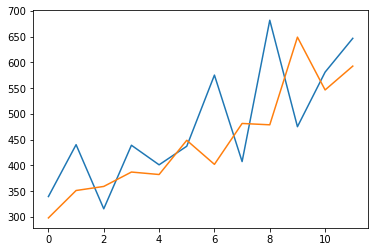

In [39]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

## Multiple repeats

In [41]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)
 
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

1) Test RMSE: 93.110
2) Test RMSE: 101.995
3) Test RMSE: 96.564
4) Test RMSE: 97.119
5) Test RMSE: 97.892
6) Test RMSE: 97.363
7) Test RMSE: 101.736
8) Test RMSE: 99.535
9) Test RMSE: 96.963
10) Test RMSE: 98.745
11) Test RMSE: 97.669
12) Test RMSE: 114.456
13) Test RMSE: 108.324


KeyboardInterrupt: 